<font color="red"> <font size="6">Transfer learning with BiT </font> 
[BiT](https://keras.io/examples/vision/bit/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#tfds.disable_progress_bar()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
SEEDS = 42

np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

/Users/carloscardona/miniforge3/envs/breast_cnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Num GPUs Available:  1


<font color="red"> <font size="4">Lets choose between full and patches images dataset </font> 
Preparing my own data set in tfds format. 

In [2]:
path_base_data_full='/Users/carloscardona/Dropbox (Personal)/Programming_N_related/Startup_ideas/Breast cancer\
/My_own_app/data_full_images/'
path_base_data_patches='/Users/carloscardona/Dropbox (Personal)/Programming_N_related/Startup_ideas/Breast cancer\
/My_own_app/data_patches_images/'
full=False
if full:
    builder = tfds.ImageFolder(path_base_data_full)
    DATASET_SIZE= 1316
else:
    builder = tfds.ImageFolder(path_base_data_patches)
    DATASET_SIZE= 1231

2022-10-24 21:26:08.861137: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [3]:
#from pathlib import Path
import pathlib
#BASE_DIR = Path(__file__).resolve().parent.parent
base_dir=pathlib.Path().absolute()

In [4]:
base_dir

PosixPath('/Users/carloscardona/Dropbox (Personal)/Programming_N_related/Startup_ideas/Breast cancer/My_own_app/model_1')

In [5]:
print(builder.info) 

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/Users/carloscardona/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=378, num_shards=1>,
        'train': <SplitInfo num_examples=1316, num_shards=1>,
    },
    citation="""""",
)


In [6]:
# take data from train folder
ds_t = builder.as_dataset(split='train', shuffle_files=True, as_supervised=True)

Metal device set to: Apple M1 Pro


2022-10-24 21:26:19.665993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-24 21:26:19.666216: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
ds_t

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Take all data from training folder

2022-10-24 21:26:21.999051: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


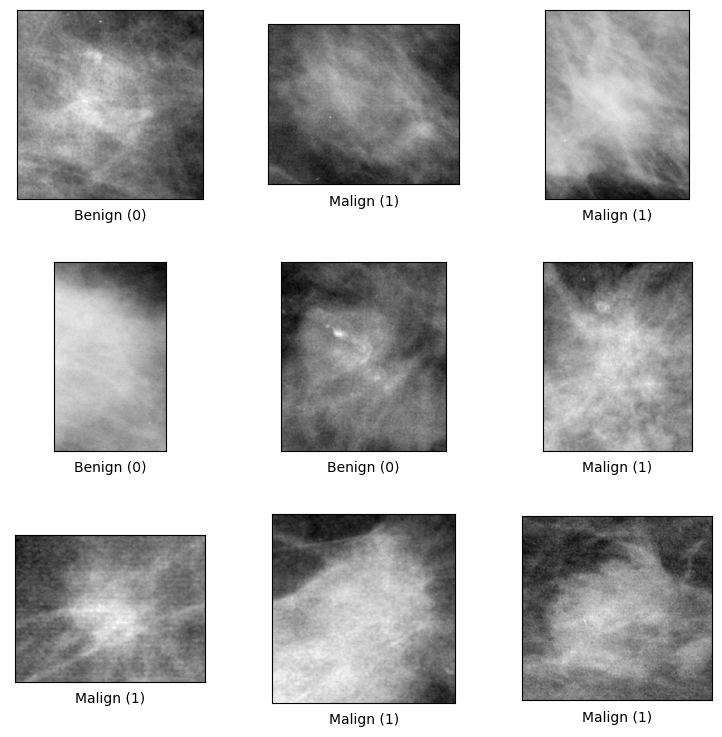

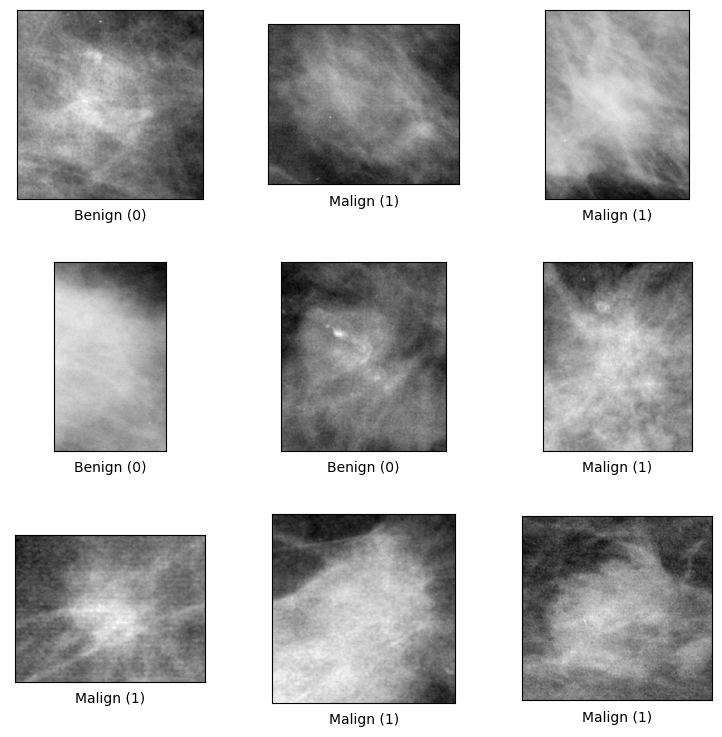

In [8]:
tfds.show_examples(ds_t, builder.info)

Spliting data into training and validation

In [9]:
train_size = int(0.85 * DATASET_SIZE)
#val_size = int(0.2 * DATASET_SIZE)
#test_size = int(0.15 * DATASET_SIZE)

#ds_t = ds_t.shuffle()
train_ds = ds_t.take(train_size)
val_ds = ds_t.skip(train_size)

### Define hyperparameters

In [137]:
RESIZE_TO = 100
#CROP_TO = 60
BATCH_SIZE = 32
STEPS_PER_EPOCH = 40
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
NUM_CLASSES = 2  # number of classes
SCHEDULE_LENGTH = 800  
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
]  # more the dataset size the schedule length increase

### Define preprocessing helper functions

In [138]:
@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    #image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)


@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)


DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 100 + 1  # To ensure at least there are 50 epochs of training


In [139]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [140]:
# Training pipeline
pipeline_train = (
    train_ds.shuffle(100)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    val_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


In [84]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

### Create BigTransfer (BiT) model
To create the new model, we:

Cut off the BiT model’s original head. This leaves us with the “pre-logits” output. We do not have to do this if we use the ‘feature extractor’ models (i.e. all those in subdirectories titled feature_vectors), since for those models the head has already been cut off.

Add a new head with the number of outputs equal to the number of classes of our new task. Note that it is important that we initialise the head to all zeroes.

In [141]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [142]:
learning_rate = 0.003 * BATCH_SIZE / 256

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [143]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [155]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=4, restore_best_weights=True
    )
]
train_callbacks2 = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

In [157]:
history_BiT =model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
    #callbacks=callbacks
)

Epoch 1/20
40/40 [==============================] - 7s 178ms/step - loss: 0.4426 - accuracy: 0.7930 - val_loss: 0.4908 - val_accuracy: 0.7741
Epoch 2/20
40/40 [==============================] - 7s 176ms/step - loss: 0.4447 - accuracy: 0.7977 - val_loss: 0.4623 - val_accuracy: 0.7852
Epoch 3/20
40/40 [==============================] - 7s 169ms/step - loss: 0.4507 - accuracy: 0.7828 - val_loss: 0.4395 - val_accuracy: 0.8037
Epoch 4/20
40/40 [==============================] - 7s 167ms/step - loss: 0.4534 - accuracy: 0.7953 - val_loss: 0.4930 - val_accuracy: 0.7741
Epoch 5/20
40/40 [==============================] - 7s 167ms/step - loss: 0.4280 - accuracy: 0.8023 - val_loss: 0.4698 - val_accuracy: 0.7963
Epoch 6/20
40/40 [==============================] - 7s 165ms/step - loss: 0.4450 - accuracy: 0.7914 - val_loss: 0.5049 - val_accuracy: 0.7519


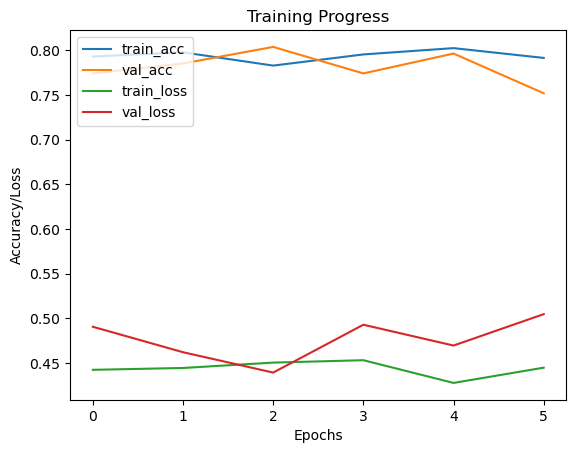

In [158]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history_BiT)

### Save model

In [148]:
#!mkdir -p saved_model
model.save('saved_model/model_bit_patches_3')

INFO:tensorflow:Assets written to: saved_model/model_bit_patches_3/assets


INFO:tensorflow:Assets written to: saved_model/model_bit_patches_3/assets


### Evaluate model

In [147]:
# with validation dataset
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 2s 118ms/step - loss: 0.4455 - accuracy: 0.7815
Accuracy: 78.15%


### Test dataset

In [20]:
ds_test = builder.as_dataset(split='test', shuffle_files=True, as_supervised=True)
ds_test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

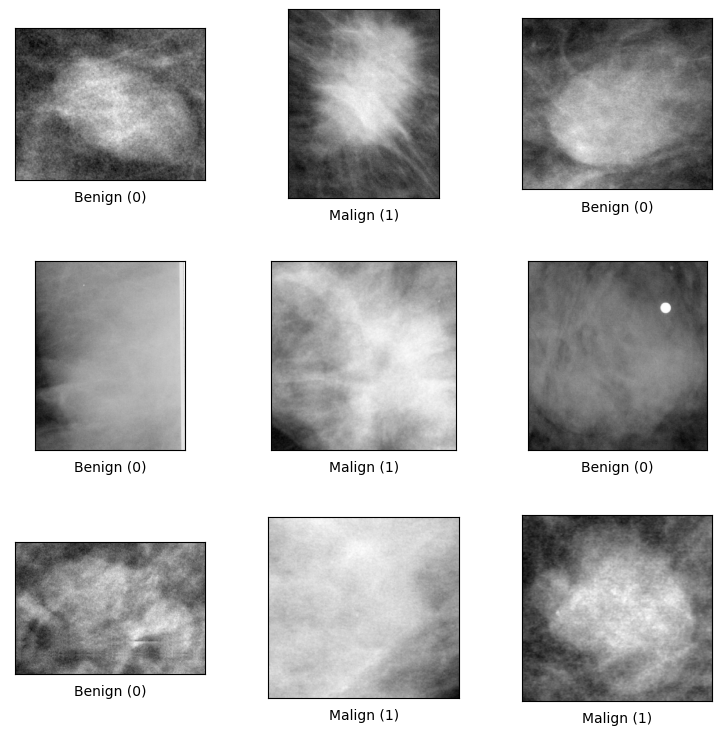

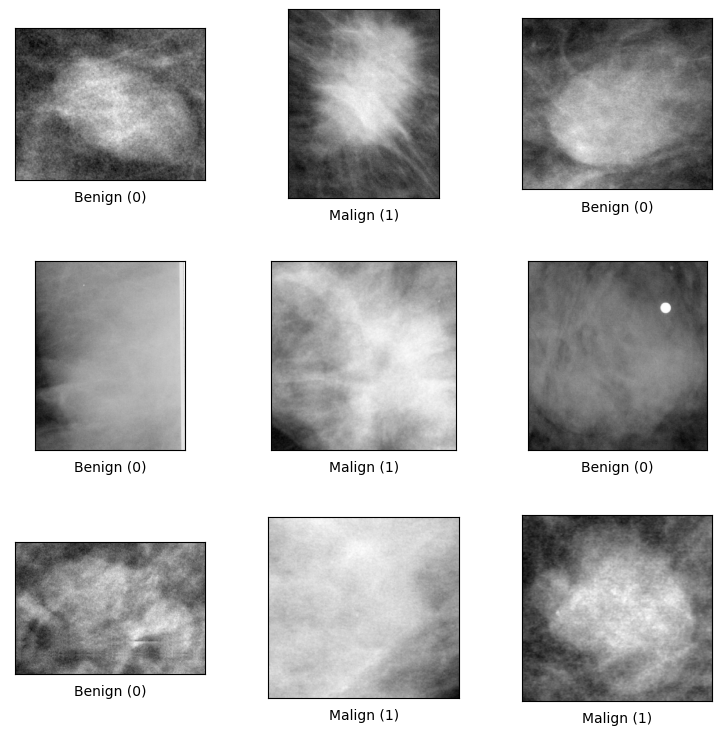

In [21]:
tfds.show_examples(ds_t, builder.info)

In [22]:
#test pipeline
pipeline_test = (
    ds_test.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [23]:
# with test dataset
accuracy_test = model.evaluate(pipeline_test)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy_test))

12/12 [==============================] - 3s 286ms/step - loss: 0.5901 - accuracy: 0.7328
Accuracy: 73.28%


<font color="red"> <font size="5">What about INbreast dataset </font> 

In [189]:
path_inbreast="/Users/carloscardona/Dropbox (Personal)/Programming_N_related/Startup_ideas/Breast cancer\
data_INbreast"
df_inbreast=pd.read_

In [188]:
!pwd

/Users/carloscardona/Dropbox (Personal)/Programming_N_related/Startup_ideas/Breast cancer/My_own_app/model_1
